In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import Image
import timm 

In [2]:
def load_data(dataname, quality):
    # data : "f2f_data", "nt_data"
    # quality : "high", "low"
    
    if quality == "high" :
        directory = "High Quality/"
        
    elif quality == "low":
        directory = "Low Quality/"
        
    else:
        return "filename exception"
    
    if dataname == "f2f_data" :
        directory += "f2f_data/"
        
    elif dataname == "nt_data" :
        directory += "nt_data/"
    else:
        return "filename exception"
    
    train_path = directory + "train/"
    test_path = directory + "test/"
    val_path = directory + "val/"
    
    # make a transform 
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    val_images = []
    val_labels = []
    
    # train load
    for filename in os.listdir(train_path):
        image_path = os.path.join(train_path, filename)
        if filename[:4] == "fake":
            label = 1  # 1 for fake
        else:
            label = 0  # 0 for real
        image = Image.open(image_path)
        image_tensor = preprocess(image)
        train_images.append(image_tensor)
        train_labels.append(label)

    # test load
    for filename in os.listdir(test_path):
        image_path = os.path.join(test_path, filename)
        if filename[:4] == "fake":
            label = 1  # 1 for fake
        else:
            label = 0  # 0 for real
        image = Image.open(image_path)
        image_tensor = preprocess(image)
        test_images.append(image_tensor)
        test_labels.append(label)

    # val load
    for filename in os.listdir(val_path):
        image_path = os.path.join(val_path, filename)
        if filename[:4] == "fake":
            label = 1  # 1 for fake
        else:
            label = 0  # 0 for real
        image = Image.open(image_path)
        image_tensor = preprocess(image)
        val_images.append(image_tensor)
        val_labels.append(label)
        
    train_images = torch.stack(train_images, dim=0)
    test_images = torch.stack(test_images, dim=0)
    val_images = torch.stack(val_images, dim=0)
    train_labels = torch.tensor(train_labels)
    test_labels = torch.tensor(test_labels)
    val_labels = torch.tensor(val_labels)
    
    train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
    test_dataset = torch.utils.data.TensorDataset(test_images, test_labels)
    val_dataset = torch.utils.data.TensorDataset(val_images, val_labels)
    
    return train_dataset, test_dataset, val_dataset


In [3]:
def train_val_model(pre_model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # list of loss, acc for plot
    train_loss_acc = []
    val_loss_acc = []
    
    # train
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_acc = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # to gpu

            optimizer.zero_grad()
            outputs = model(inputs) # forward
            
            loss = criterion(outputs, labels) # calculate loss with loss function
            
            
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)
            
            loss.backward() # train -> backward to update weight
            optimizer.step()
            
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_acc / len(train_loader.dataset)
                
        # validation
        with torch.no_grad():
            val_loss = 0.0
            val_acc = 0.0
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device) # to gpu

                outputs = model(inputs) # forward
                loss = criterion(outputs, labels) # calculate loss with loss function
                
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels.data)

            val_loss = val_loss / len(val_loader.dataset)
            val_acc = val_acc / len(val_loader.dataset)
        
        
        #print("Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}"
        #      .format(epoch + 1, num_epochs, train_loss, train_acc))
        #print("Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}"
        #      .format(epoch + 1, num_epochs, val_loss, val_acc))
        
        train_loss_acc.append((train_loss,train_acc))
        val_loss_acc.append((val_loss, val_acc))
        
    return train_loss_acc, val_loss_acc
    

In [4]:
from sklearn.metrics import f1_score, recall_score, precision_score
def eval_model(test_loader, criterion):
    test_loss_acc = []
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        y_true = []
        y_pred = []
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # to gpu

            outputs = model(inputs) # forward
            loss = criterion(outputs, labels) # calculate loss with loss function
                
            test_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_acc += torch.sum(preds == labels.data)
            y_true.extend(labels.cpu().numpy()) # labels to cpu and to numpy array
            y_pred.extend(preds.cpu().numpy()) # preds to cpu and to numpy array

        test_loss = test_loss / len(test_loader.dataset)
        test_acc = test_acc / len(test_loader.dataset)
        f1 = f1_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        
        
    print("Test Loss: {:.4f}, Test Accuracy: {:.4f}, F1 Score: {:.4f}, Recall: {:.4f}, Precision: {:.4f}"
              .format(test_loss, test_acc, f1, recall, precision))
    
    test_loss_acc.append((test_loss,test_acc, f1, recall, precision))

    return test_loss_acc

In [5]:
import pandas as pd
import numpy as np
def eval_picture():
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    csv_file = 'data/your_prediction.csv'  # 파일 경로를 적절히 수정해주세요

    df = pd.read_csv(csv_file)

    for index, row in df.iterrows():
        directory = row['video']
        image_filename = row['face']

        # 파일 경로 조합
        image_path = 'data/' + directory + '/' + image_filename           
        image = Image.open(image_path)
        image_tensor = preprocess(image).unsqueeze(0).to(device)  # 배치 차원 추가
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = F.softmax(outputs, dim=1)
            #print( "image_path : ", image_path , np.round(probabilities.cpu().numpy(), 2))
            print(np.round(probabilities[0][0].cpu().numpy(), 2),'\t',np.round(probabilities[0][1].cpu().numpy(), 2))

In [6]:
import matplotlib.pyplot as plt

def plottv(train_loss_acc, val_loss_acc, num_epochs):
    x = range(1, num_epochs+1)
    tloss_y = []
    vloss_y = []
    tacc_y = []
    vacc_y = []
    for tloss, tacc in train_loss_acc:
        tloss_y.append(tloss)
        tacc_y.append(tacc.item())
        
    for vloss, vacc in val_loss_acc:
        vloss_y.append(vloss)
        vacc_y.append(vacc.item())
        
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(x, tloss_y, label="train")
    plt.plot(x, vloss_y, label="validation")
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.plot(x, tacc_y, label="train")
    plt.plot(x, vacc_y, label="validation")
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [7]:
def train(model, train_data, test_data, val_data):
    train_loader =  torch.utils.data.DataLoader(f2f_high_train, batch_size=32, shuffle=True)
    test_loader =  torch.utils.data.DataLoader(f2f_high_test, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(f2f_high_val, batch_size=32, shuffle=True)

    # criterion, optimizer, epochs
    criterion = nn.CrossEntropyLoss() # crossentropy loss
    optimizer = optim.Adam(model.parameters(), lr=0.001) # optimizer
    num_epochs = 60 # epochs

    train_loss_acc, val_loss_acc = train_val_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)
    test_loss_acc = eval_model(test_loader, criterion)
    plottv(train_loss_acc, val_loss_acc, num_epochs)
    

In [8]:
# load all of data
# load_data return tuple of TensorDataset
f2f_high_train, f2f_high_test, f2f_high_val = load_data("f2f_data", "high")
f2f_low_train, f2f_low_test, f2f_low_val = load_data("f2f_data", "low")

nt_high_train, nt_high_test, nt_high_val = load_data("nt_data", "high")
nt_low_train, nt_low_test, nt_low_val = load_data("nt_data", "low")

In [9]:
device = 'cuda:0'

Face2Face HIGH EfficientnetB0

Test Loss: 0.0949, Test Accuracy: 0.9774, F1 Score: 0.9774, Recall: 0.9799, Precision: 0.9750


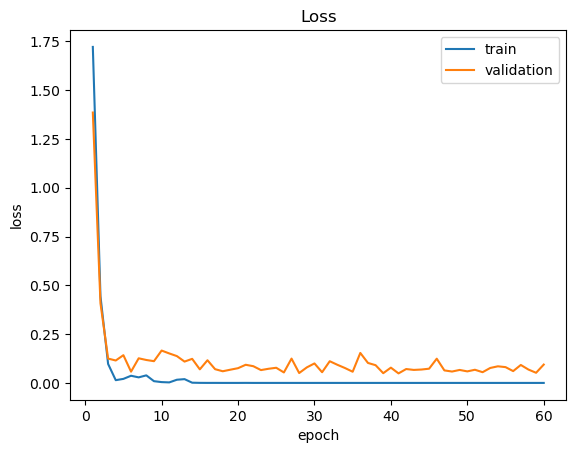

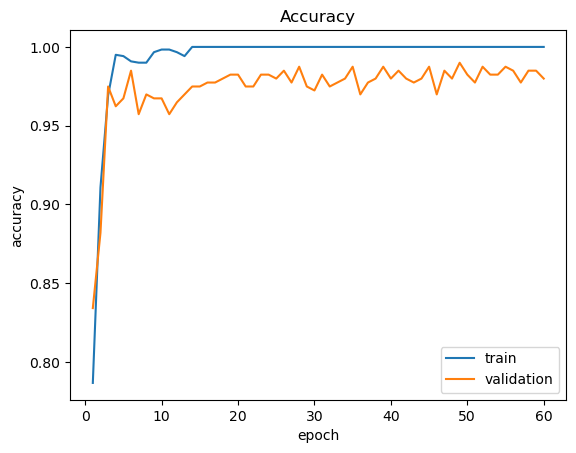

In [10]:
model = timm.create_model('efficientnet_b0',num_classes=2, pretrained=True).to(device) 
train(model, f2f_high_train, f2f_high_test, f2f_high_val)

In [11]:
eval_picture()

0.96 	 0.04
1.0 	 0.0
1.0 	 0.0
0.96 	 0.04
0.98 	 0.02
0.99 	 0.01
0.66 	 0.34
0.93 	 0.07
1.0 	 0.0
0.98 	 0.02
0.93 	 0.07
1.0 	 0.0
0.97 	 0.03
0.99 	 0.01
0.99 	 0.01
0.94 	 0.06
1.0 	 0.0
0.99 	 0.01
0.51 	 0.49
0.6 	 0.4
0.89 	 0.11
0.73 	 0.27
0.15 	 0.85
0.94 	 0.06
0.9 	 0.1
0.92 	 0.08
0.96 	 0.04
0.84 	 0.16
0.87 	 0.13
0.97 	 0.03
0.99 	 0.01
0.98 	 0.02
0.72 	 0.28
0.98 	 0.02
0.99 	 0.01
1.0 	 0.0
0.47 	 0.53
0.27 	 0.73
0.98 	 0.02
0.49 	 0.51
0.44 	 0.56
0.87 	 0.13
0.99 	 0.01
0.97 	 0.03
0.43 	 0.57
0.97 	 0.03
0.92 	 0.08
0.94 	 0.06
0.89 	 0.11
0.92 	 0.08
0.54 	 0.46
0.48 	 0.52
0.83 	 0.17
0.4 	 0.6
0.98 	 0.02
1.0 	 0.0
0.45 	 0.55
0.68 	 0.32
0.27 	 0.73
0.96 	 0.04
1.0 	 0.0
0.68 	 0.32
0.92 	 0.08
0.99 	 0.01
0.97 	 0.03
0.91 	 0.09
0.93 	 0.07
0.77 	 0.23
0.5 	 0.5
0.96 	 0.04
0.87 	 0.13
0.66 	 0.34
0.22 	 0.78
0.56 	 0.44


Face2Face HIGH Xception

C:\Users\SeungHyuck\anaconda3\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Test Loss: 0.1599, Test Accuracy: 0.9774, F1 Score: 0.9777, Recall: 0.9899, Precision: 0.9657


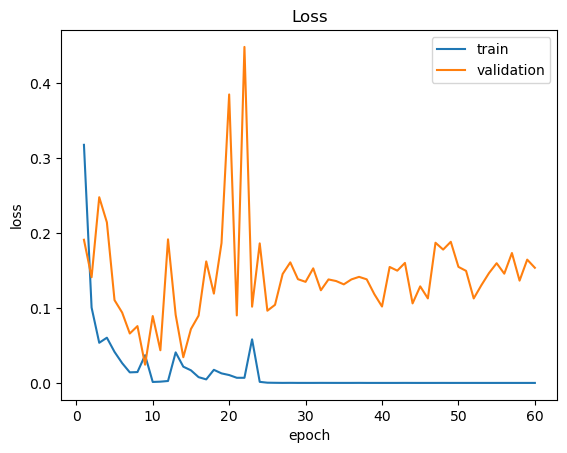

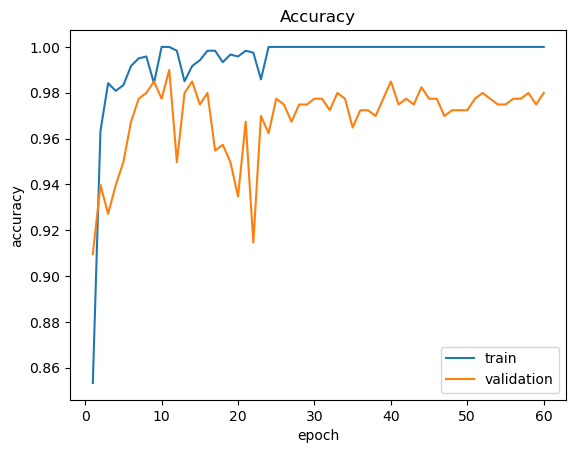

0.17 	 0.83
0.57 	 0.43
0.42 	 0.58
0.28 	 0.72
0.16 	 0.84
0.3 	 0.7
0.34 	 0.66
0.17 	 0.83
0.24 	 0.76
0.77 	 0.23
0.88 	 0.12
0.3 	 0.7
0.56 	 0.44
0.8 	 0.2
0.21 	 0.79
0.82 	 0.18
0.83 	 0.17
0.49 	 0.51
0.72 	 0.28
0.59 	 0.41
0.56 	 0.44
0.71 	 0.29
0.2 	 0.8
0.7 	 0.3
0.78 	 0.22
0.56 	 0.44
0.68 	 0.32
0.82 	 0.18
0.14 	 0.86
0.49 	 0.51
0.35 	 0.65
0.55 	 0.45
0.58 	 0.42
0.16 	 0.84
0.2 	 0.8
0.34 	 0.66
0.45 	 0.55
0.6 	 0.4
0.57 	 0.43
0.64 	 0.36
0.47 	 0.53
0.31 	 0.69
0.35 	 0.65
0.63 	 0.37
0.17 	 0.83
0.51 	 0.49
0.27 	 0.73
0.6 	 0.4
0.78 	 0.22
0.55 	 0.45
0.64 	 0.36
0.18 	 0.82
0.44 	 0.56
0.28 	 0.72
0.68 	 0.32
0.83 	 0.17
0.8 	 0.2
0.3 	 0.7
0.61 	 0.39
0.26 	 0.74
0.5 	 0.5
0.27 	 0.73
0.31 	 0.69
0.87 	 0.13
0.58 	 0.42
0.74 	 0.26
0.78 	 0.22
0.64 	 0.36
0.56 	 0.44
0.5 	 0.5
0.63 	 0.37
0.11 	 0.89
0.93 	 0.07
0.47 	 0.53


In [12]:
model = timm.create_model('xception',num_classes=2, pretrained=True).to(device)
train(model, f2f_high_train, f2f_high_test, f2f_high_val)
eval_picture()

Face2Face LOW EfficientnetB0

Test Loss: 0.0825, Test Accuracy: 0.9799, F1 Score: 0.9800, Recall: 0.9849, Precision: 0.9751


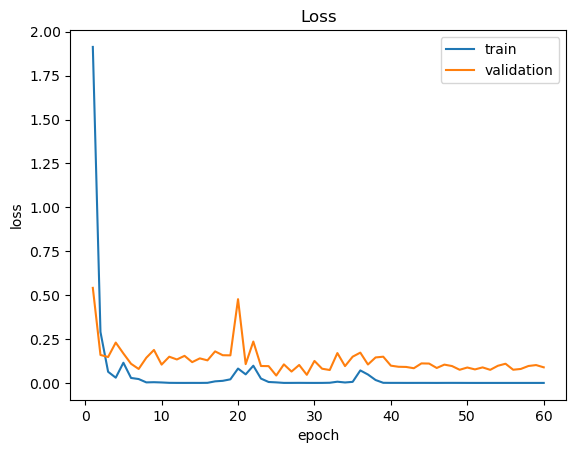

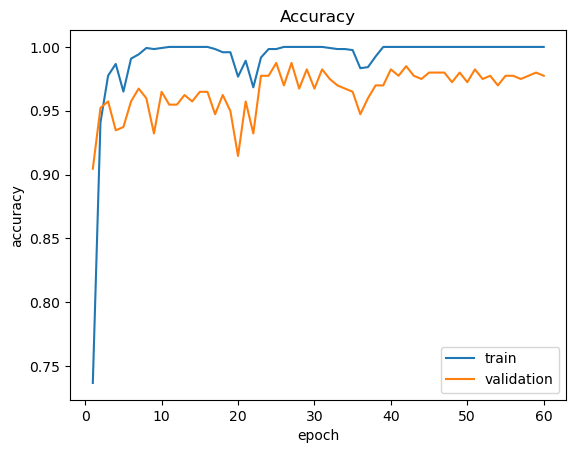

0.0 	 1.0
0.1 	 0.9
0.0 	 1.0
0.01 	 0.99
0.11 	 0.89
0.01 	 0.99
0.02 	 0.98
0.01 	 0.99
0.03 	 0.97
0.01 	 0.99
0.87 	 0.13
0.0 	 1.0
0.1 	 0.9
0.02 	 0.98
0.15 	 0.85
0.02 	 0.98
0.11 	 0.89
0.17 	 0.83
0.01 	 0.99
0.03 	 0.97
0.09 	 0.91
0.45 	 0.55
0.0 	 1.0
0.0 	 1.0
0.09 	 0.91
0.0 	 1.0
0.8 	 0.2
0.02 	 0.98
0.01 	 0.99
0.0 	 1.0
0.0 	 1.0
0.01 	 0.99
0.51 	 0.49
0.02 	 0.98
0.08 	 0.92
0.32 	 0.68
0.0 	 1.0
0.13 	 0.87
0.04 	 0.96
0.01 	 0.99
0.01 	 0.99
0.0 	 1.0
0.0 	 1.0
0.01 	 0.99
0.0 	 1.0
0.03 	 0.97
0.03 	 0.97
0.31 	 0.69
0.23 	 0.77
0.0 	 1.0
0.05 	 0.95
0.0 	 1.0
0.27 	 0.73
0.0 	 1.0
0.04 	 0.96
0.07 	 0.93
0.03 	 0.97
0.0 	 1.0
0.0 	 1.0
0.0 	 1.0
0.0 	 1.0
0.15 	 0.85
0.0 	 1.0
0.0 	 1.0
0.02 	 0.98
0.01 	 0.99
0.02 	 0.98
0.0 	 1.0
0.0 	 1.0
0.07 	 0.93
0.01 	 0.99
0.0 	 1.0
0.02 	 0.98
0.0 	 1.0


In [13]:
model = timm.create_model('efficientnet_b0',num_classes=2, pretrained=True).to(device)
train(model, f2f_low_train, f2f_low_test, f2f_low_val)
eval_picture()

Face2Face LOW Xception

C:\Users\SeungHyuck\anaconda3\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Test Loss: 0.1553, Test Accuracy: 0.9623, F1 Score: 0.9620, Recall: 0.9548, Precision: 0.9694


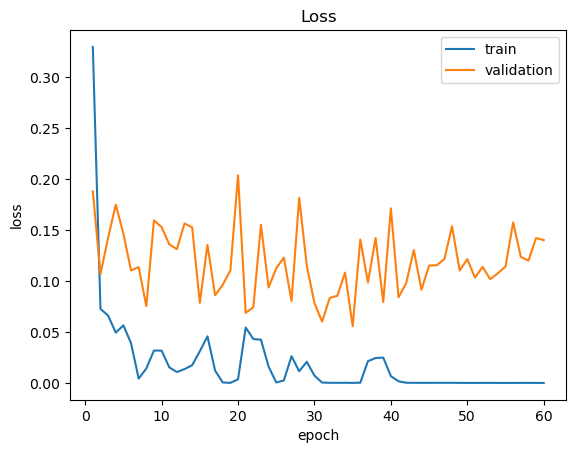

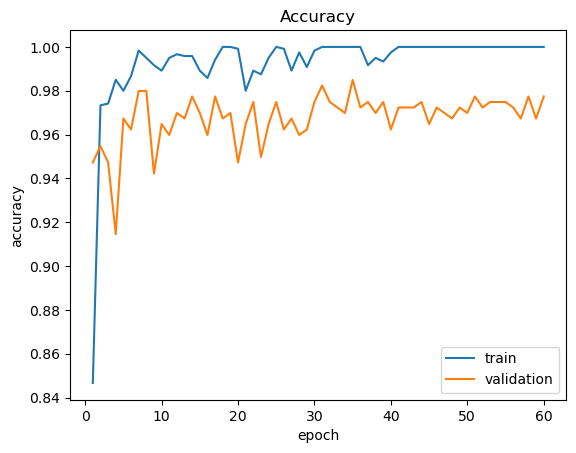

0.29 	 0.71
0.99 	 0.01
0.87 	 0.13
0.79 	 0.21
0.96 	 0.04
0.66 	 0.34
0.85 	 0.15
0.94 	 0.06
0.71 	 0.29
0.53 	 0.47
0.97 	 0.03
0.75 	 0.25
0.68 	 0.32
0.68 	 0.32
0.66 	 0.34
0.38 	 0.62
0.46 	 0.54
0.41 	 0.59
0.98 	 0.02
0.89 	 0.11
0.85 	 0.15
0.54 	 0.46
0.29 	 0.71
0.91 	 0.09
0.86 	 0.14
0.42 	 0.58
0.41 	 0.59
0.43 	 0.57
0.19 	 0.81
0.84 	 0.16
0.9 	 0.1
0.73 	 0.27
0.76 	 0.24
0.74 	 0.26
0.48 	 0.52
0.71 	 0.29
0.73 	 0.27
0.71 	 0.29
0.85 	 0.15
0.4 	 0.6
0.67 	 0.33
0.66 	 0.34
0.66 	 0.34
0.64 	 0.36
0.51 	 0.49
0.79 	 0.21
0.81 	 0.19
0.59 	 0.41
0.72 	 0.28
0.49 	 0.51
0.8 	 0.2
0.85 	 0.15
0.96 	 0.04
0.7 	 0.3
0.93 	 0.07
0.64 	 0.36
0.97 	 0.03
0.55 	 0.45
0.8 	 0.2
0.97 	 0.03
0.7 	 0.3
0.56 	 0.44
0.93 	 0.07
0.72 	 0.28
0.66 	 0.34
0.87 	 0.13
0.94 	 0.06
0.85 	 0.15
0.84 	 0.16
0.98 	 0.02
0.67 	 0.33
0.64 	 0.36
0.69 	 0.31
0.86 	 0.14


In [14]:
model = timm.create_model('xception',num_classes=2, pretrained=True).to(device)
train(model, f2f_low_train, f2f_low_test, f2f_low_val)
eval_picture()

NeuralTexture HIGH EfficientnetB0

Test Loss: 0.1329, Test Accuracy: 0.9724, F1 Score: 0.9724, Recall: 0.9749, Precision: 0.9700


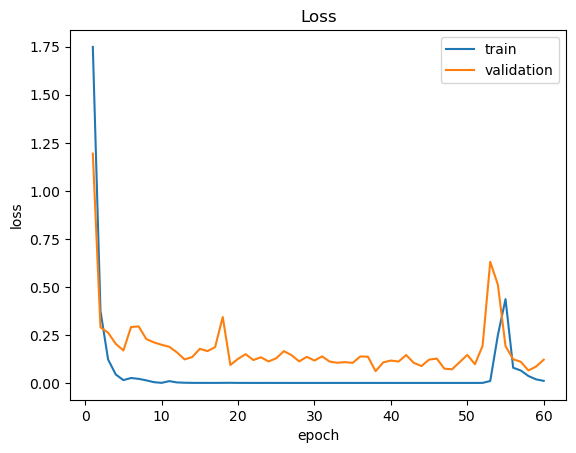

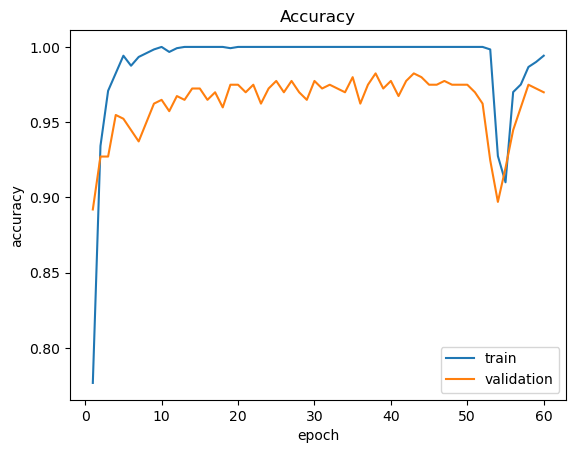

1.0 	 0.0
1.0 	 0.0
1.0 	 0.0
1.0 	 0.0
0.0 	 1.0
1.0 	 0.0
0.77 	 0.23
0.99 	 0.01
0.99 	 0.01
0.99 	 0.01
0.99 	 0.01
0.74 	 0.26
0.0 	 1.0
1.0 	 0.0
0.11 	 0.89
0.0 	 1.0
0.0 	 1.0
0.0 	 1.0
1.0 	 0.0
0.17 	 0.83
0.81 	 0.19
0.99 	 0.01
1.0 	 0.0
1.0 	 0.0
0.25 	 0.75
0.0 	 1.0
0.0 	 1.0
0.74 	 0.26
1.0 	 0.0
1.0 	 0.0
1.0 	 0.0
1.0 	 0.0
1.0 	 0.0
0.95 	 0.05
1.0 	 0.0
0.15 	 0.85
0.98 	 0.02
0.02 	 0.98
0.62 	 0.38
1.0 	 0.0
1.0 	 0.0
1.0 	 0.0
0.42 	 0.58
0.94 	 0.06
0.35 	 0.65
0.88 	 0.12
0.04 	 0.96
0.99 	 0.01
0.95 	 0.05
0.63 	 0.37
0.0 	 1.0
0.0 	 1.0
0.52 	 0.48
0.55 	 0.45
0.97 	 0.03
0.94 	 0.06
0.98 	 0.02
0.95 	 0.05
1.0 	 0.0
0.34 	 0.66
0.98 	 0.02
0.92 	 0.08
1.0 	 0.0
1.0 	 0.0
0.09 	 0.91
0.63 	 0.37
0.39 	 0.61
0.08 	 0.92
0.95 	 0.05
0.0 	 1.0
0.97 	 0.03
0.65 	 0.35
1.0 	 0.0
0.18 	 0.82


In [15]:
model = timm.create_model('efficientnet_b0',num_classes=2, pretrained=True).to(device)
train(model, nt_high_train, nt_high_test, nt_high_val)
eval_picture()

NeuralTexture HIGH Xception

C:\Users\SeungHyuck\anaconda3\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Test Loss: 0.3529, Test Accuracy: 0.9271, F1 Score: 0.9298, Recall: 0.9648, Precision: 0.8972


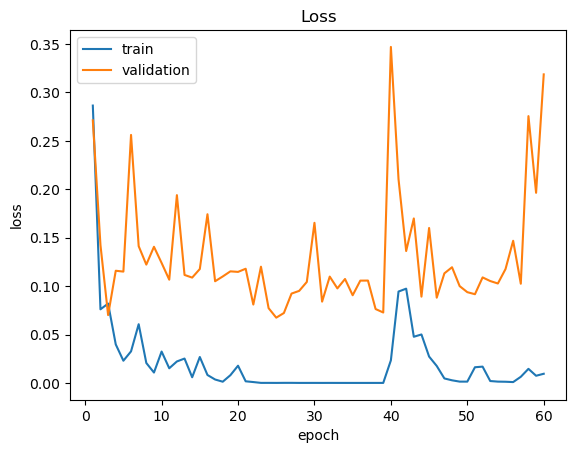

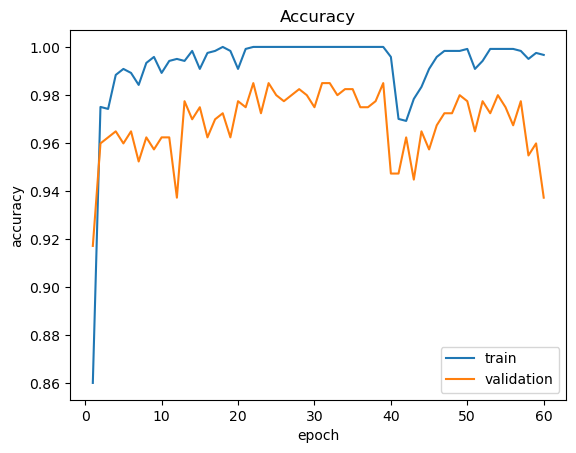

0.61 	 0.39
0.98 	 0.02
0.94 	 0.06
0.98 	 0.02
0.8 	 0.2
0.87 	 0.13
0.89 	 0.11
0.89 	 0.11
1.0 	 0.0
0.98 	 0.02
0.98 	 0.02
0.96 	 0.04
0.95 	 0.05
0.87 	 0.13
0.97 	 0.03
0.73 	 0.27
0.7 	 0.3
0.85 	 0.15
0.88 	 0.12
0.99 	 0.01
0.93 	 0.07
0.95 	 0.05
0.56 	 0.44
0.91 	 0.09
0.78 	 0.22
0.81 	 0.19
0.99 	 0.01
0.95 	 0.05
0.98 	 0.02
0.99 	 0.01
0.86 	 0.14
0.99 	 0.01
0.99 	 0.01
0.93 	 0.07
0.84 	 0.16
0.98 	 0.02
0.99 	 0.01
0.96 	 0.04
0.96 	 0.04
1.0 	 0.0
0.87 	 0.13
0.77 	 0.23
0.97 	 0.03
0.94 	 0.06
0.91 	 0.09
0.92 	 0.08
1.0 	 0.0
0.53 	 0.47
0.85 	 0.15
0.91 	 0.09
0.97 	 0.03
0.9 	 0.1
0.99 	 0.01
0.73 	 0.27
0.77 	 0.23
0.72 	 0.28
0.9 	 0.1
0.75 	 0.25
0.9 	 0.1
0.98 	 0.02
0.84 	 0.16
0.92 	 0.08
0.8 	 0.2
0.71 	 0.29
0.99 	 0.01
0.97 	 0.03
0.96 	 0.04
0.97 	 0.03
0.96 	 0.04
0.93 	 0.07
1.0 	 0.0
0.88 	 0.12
1.0 	 0.0
0.87 	 0.13


In [16]:
model = timm.create_model('xception',num_classes=2, pretrained=True).to(device)
train(model, nt_high_train, nt_high_test, nt_high_val)
eval_picture()

NeuralTexture LOW EfficientnetB0

Test Loss: 0.0722, Test Accuracy: 0.9824, F1 Score: 0.9823, Recall: 0.9749, Precision: 0.9898


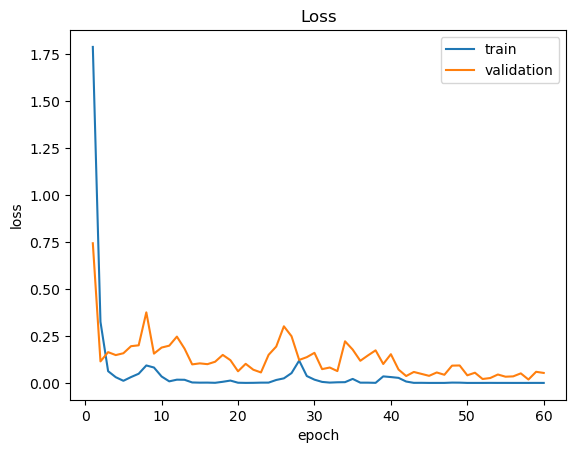

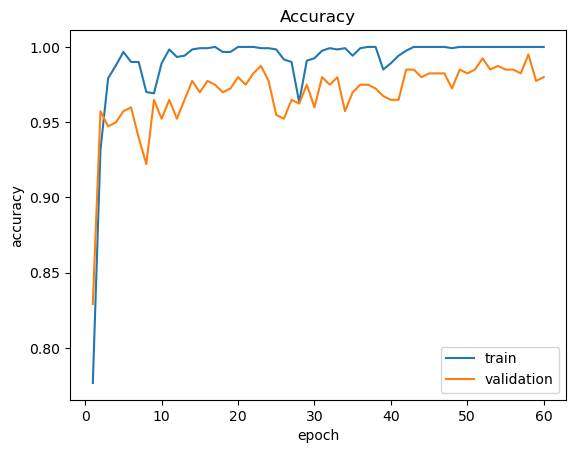

0.48 	 0.52
0.06 	 0.94
0.57 	 0.43
0.13 	 0.87
0.01 	 0.99
0.02 	 0.98
0.1 	 0.9
0.69 	 0.31
0.42 	 0.58
0.04 	 0.96
0.0 	 1.0
0.01 	 0.99
0.05 	 0.95
0.49 	 0.51
0.06 	 0.94
0.01 	 0.99
0.01 	 0.99
0.7 	 0.3
0.52 	 0.48
0.7 	 0.3
0.89 	 0.11
0.84 	 0.16
0.07 	 0.93
0.11 	 0.89
0.81 	 0.19
0.77 	 0.23
0.44 	 0.56
0.0 	 1.0
1.0 	 0.0
0.01 	 0.99
0.9 	 0.1
0.01 	 0.99
0.46 	 0.54
0.6 	 0.4
0.0 	 1.0
0.4 	 0.6
0.06 	 0.94
0.02 	 0.98
0.01 	 0.99
0.0 	 1.0
0.96 	 0.04
0.06 	 0.94
0.0 	 1.0
0.77 	 0.23
0.0 	 1.0
0.84 	 0.16
0.02 	 0.98
0.23 	 0.77
0.03 	 0.97
0.0 	 1.0
0.25 	 0.75
0.15 	 0.85
0.28 	 0.72
0.0 	 1.0
0.99 	 0.01
0.52 	 0.48
0.04 	 0.96
0.93 	 0.07
0.99 	 0.01
0.0 	 1.0
0.0 	 1.0
0.09 	 0.91
0.14 	 0.86
0.37 	 0.63
0.96 	 0.04
0.41 	 0.59
0.55 	 0.45
0.09 	 0.91
0.39 	 0.61
0.39 	 0.61
0.04 	 0.96
0.98 	 0.02
0.01 	 0.99
0.56 	 0.44


In [17]:
model = timm.create_model('efficientnet_b0',num_classes=2, pretrained=True).to(device)
train(model, nt_low_train, nt_low_test, nt_low_val)
eval_picture()

NeuralTexture LOW Xception

C:\Users\SeungHyuck\anaconda3\lib\site-packages\timm\models\_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Test Loss: 0.1550, Test Accuracy: 0.9648, F1 Score: 0.9645, Recall: 0.9548, Precision: 0.9744


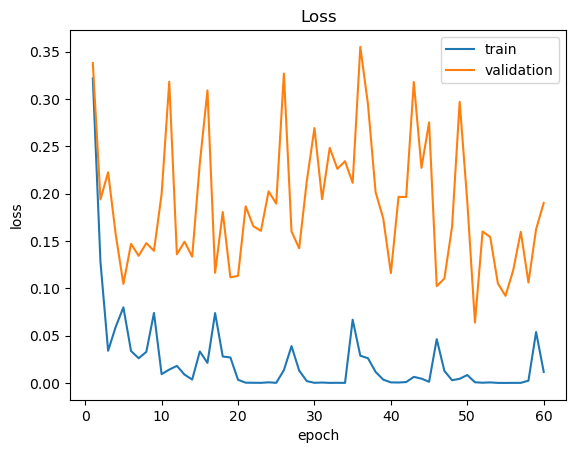

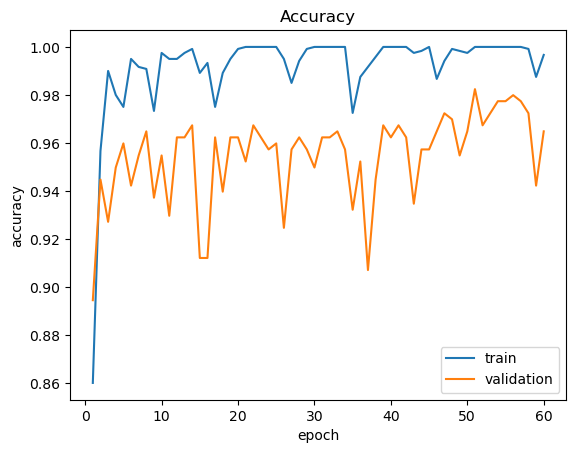

0.46 	 0.54
0.29 	 0.71
0.59 	 0.41
0.16 	 0.84
0.31 	 0.69
0.36 	 0.64
0.2 	 0.8
0.92 	 0.08
0.12 	 0.88
0.28 	 0.72
0.27 	 0.73
0.08 	 0.92
0.45 	 0.55
0.65 	 0.35
0.2 	 0.8
0.61 	 0.39
0.49 	 0.51
0.93 	 0.07
0.33 	 0.67
0.28 	 0.72
0.35 	 0.65
0.21 	 0.79
0.11 	 0.89
0.56 	 0.44
0.12 	 0.88
0.76 	 0.24
0.23 	 0.77
0.12 	 0.88
0.29 	 0.71
0.78 	 0.22
0.41 	 0.59
0.24 	 0.76
0.33 	 0.67
0.82 	 0.18
0.86 	 0.14
0.17 	 0.83
0.21 	 0.79
0.59 	 0.41
0.59 	 0.41
0.72 	 0.28
0.56 	 0.44
0.16 	 0.84
0.17 	 0.83
0.05 	 0.95
0.8 	 0.2
0.08 	 0.92
0.46 	 0.54
0.57 	 0.43
0.02 	 0.98
0.11 	 0.89
0.58 	 0.42
0.2 	 0.8
0.88 	 0.12
0.27 	 0.73
0.14 	 0.86
0.42 	 0.58
0.17 	 0.83
0.12 	 0.88
0.25 	 0.75
0.21 	 0.79
0.13 	 0.87
0.27 	 0.73
0.14 	 0.86
0.27 	 0.73
0.79 	 0.21
0.93 	 0.07
0.33 	 0.67
0.78 	 0.22
0.11 	 0.89
0.05 	 0.95
0.19 	 0.81
0.38 	 0.62
0.05 	 0.95
0.74 	 0.26


In [18]:
model = timm.create_model('xception',num_classes=2, pretrained=True).to(device)
train(model, nt_low_train, nt_low_test, nt_low_val)
eval_picture()